In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import RandomNormal
from sklearn.datasets import load_iris,make_classification,make_regression
from sklearn.model_selection import train_test_split
from PIL import Image

In [21]:
plt.rc('font',family = 'malgun gothic')

plt.rcParams['axes.unicode_minus'] = False

In [22]:
X,Y = make_regression(n_features = 5)

display(X[:5])
display(Y[:5])

array([[ 0.18333779, -1.78836664, -0.2301067 , -0.36267684,  1.15035226],
       [-0.81462323, -0.04549743, -1.49551776,  0.05593002,  0.37066571],
       [-0.31077727,  2.11891644,  0.51672801, -1.90189066,  0.52298041],
       [ 0.30474871, -0.86032478,  0.91646215,  2.25924373,  0.55299236],
       [ 1.57207482, -0.34136491,  0.31186969,  0.6394778 , -0.09370697]])

array([-142.37905904, -136.92913067,  220.57076942,   10.02414746,
         84.41517243])

##### 초기 딥러닝 모델의 활성화 함수는 Sigmoid 였고 가중치 초기화 기법은 평균이 0이고 표준편차가 1인 곳에서 가중치를 초기화 하였다.

#### 이는 layer 의 갯수가 많지 않을 때는 잘 작동하였지만 layer 의 갯수가 늘어났을 때에는 Gradient Vanising 문제가 발생하여 업데이트가 되지 않았다.

In [23]:
def create_model(layers,fx):

    
    
    inputs = tf.keras.Input(X.shape[1:])

    x = tf.keras.layers.Dense(128, activation = fx,
                                kernel_initializer = RandomNormal(mean = 0, stddev = 1))(inputs) # 초기 딥러닝 모델은 평균이 0이고 표준편차가 1인 곳에서 가중치를 랜덤하게 뽑음

    for layer in range(layers):

        x = tf.keras.layers.Dense(128, activation = fx,
                                    kernel_initializer = RandomNormal(mean = 0, stddev = 1))(x) 

    output = tf.keras.layers.Dense(units = 1)(x)

    model = tf.keras.Model(inputs,output)
    
    return model

In [24]:
def make_plot(history,layers):

    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize = (10,5))

    ax.plot(history.history['loss'], label = 'train_loss',
                                        c = 'orange')

    ax.plot(history.history['val_loss'], label = 'valid_loss',
                                        c = 'blue')

    ax.legend()
    ax.set_title('Loss 값 변화')



    fig.suptitle(f'초기 신경망 모델의 업데이트 과정 (Layer = {layers})')

In [25]:
params = {'layers':3,
            'fx':'sigmoid'}

optimizers = {'loss':'mean_squared_error',
            'optimizer':tf.optimizers.legacy.Adam(learning_rate = 0.001),
            'metrics':'mean_squared_error'}   


model = create_model(**params)

model.compile(**optimizers)

In [26]:
x_train,x_valid,y_train,y_valid = train_test_split(X,Y,random_state = 42)

In [27]:
history = model.fit(x_train,y_train,
            epochs = 500,
            validation_data = (x_valid,y_valid),
            verbose = 0)

##### Layer 가 얕을 때의 업데이트 과정

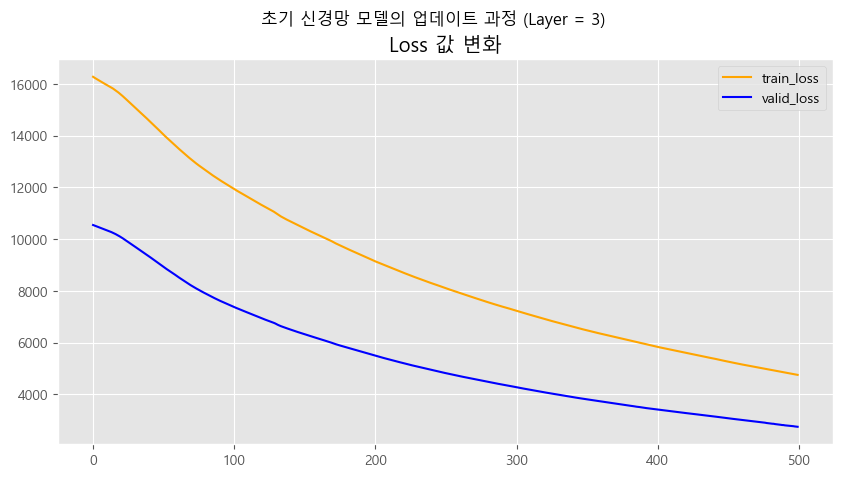

In [28]:
make_plot(history,3)

##### Layer 가 많을 때의 업데이트 과정

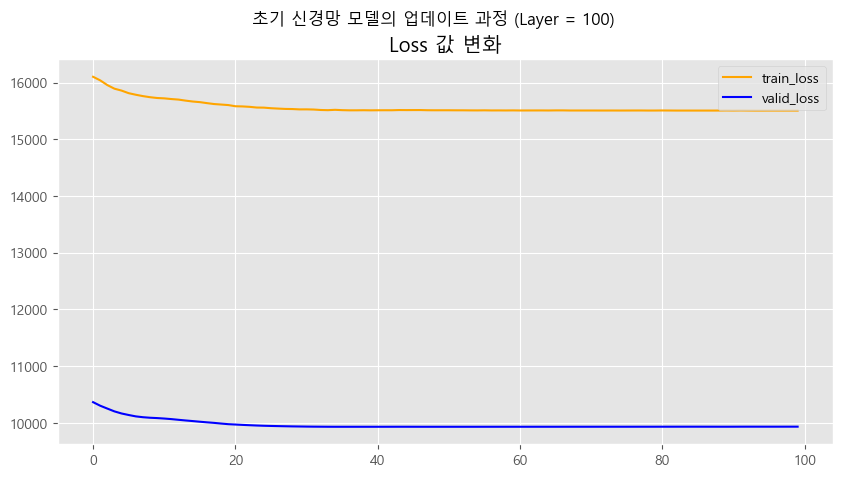

In [29]:
params = {'layers':100,
            'fx':'sigmoid'}

model = create_model(**params)

model.compile(**optimizers)


history = model.fit(x_train,y_train,
            epochs = 100,
            validation_data = (x_valid,y_valid),
            verbose = 0)

make_plot(history,100)

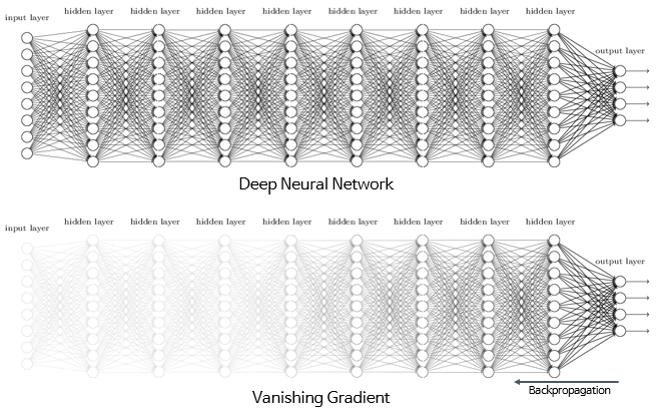

In [30]:
Image.open("C:/Users/whileduck/Desktop/img.png")

* 이는 역전파 과정에서 각 layer 를 거치며 곱해지는 Sigmoid 함수의 미분값의 영향으로 볼 수 있다.
* sigmoid 함수의 치역은 0과 0.25 의 사이로 layer 를 지나면 지날 수록 다음 node 에 곱해질 local gradient 의 값은 작아지게 되며 결국 local gradient 의 값이 0에 수렴하기 시작한 부분 이후부터는 가중치가 업데이트가 되지 않는다.

* 활성화 함수로 사용된 Sigmoid 함수의 도함수의 특징을 보게 된다면 다음과 같다.

In [31]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

def sigmoid_gradient(x): # 시그모이드 함수의 미분값
    
    return sigmoid(x) * (1 - sigmoid(x))

Text(0.5, 1.0, '시그모이드 함수와 시그모이드 도함수 그래프')

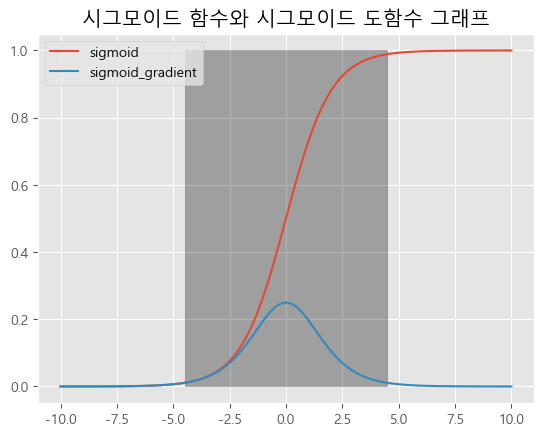

In [32]:
x = np.linspace(-10,10,100)

plt.plot(x,sigmoid(x), label = 'sigmoid')
plt.plot(x,sigmoid_gradient(x), label = 'sigmoid_gradient')

plt.fill_between([-4.5,4.5],[1,1], alpha = 0.3, color ='black')

plt.legend()
plt.title('시그모이드 함수와 시그모이드 도함수 그래프')

* 역전파 과정에서 local gradient 의 값이 곱해짐에 따라서 초기 node 에는 기울기 값이 너무 작아져 전달이 되지 않는 
* gradient vanising 문제가 발생한다.

# 1. 활성화 함수 변경 

### Relu 함수의 특징

In [33]:
def relu(x):
    
    result = []
    
    for _ in x:
        
        result.append(max(0,_)) # x 가 0보다 클 경우는 x, 작을 경우엔 0이 나오도록
            
    return result


def relu_gradient(x):
    
    return (x > 0).astype(int)

In [34]:
x = np.linspace(-10,10,100)

(-0.2, 4.0)

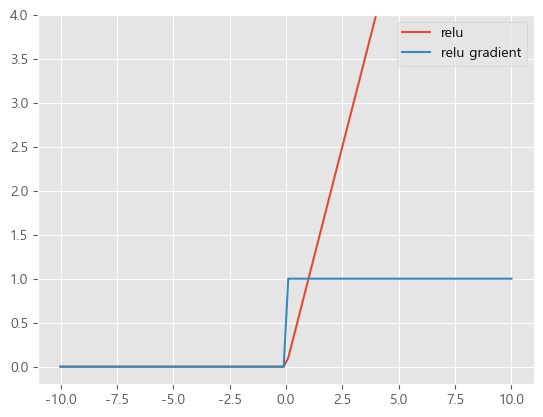

In [35]:
plt.plot(x,relu(x), label = 'relu')
plt.plot(x,relu_gradient(x),label = 'relu gradient')

plt.legend()
plt.ylim([-0.2,4])

* 시그모이드 함수는 출력값의 절대값이 너무 클 경우에는 기울기 값이 0에 가까워져 기울기 소실 문제가 발생했지만 
* relu 함수의 경우는 모든 양의 출력값에 대해서는 1의 기울기 값을 전달해 기울기 소실 문제를 많이 해결해었다.
* 또한 기울기 하강의 속도가 빠르다는 장점이 있다.

In [36]:
def create_relu_model(layers):

    inputs = tf.keras.Input(X.shape[1:])

    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dense(128, activation = 'relu',
                                kernel_initializer ='he_uniform')(x) # Relu 함수에 적합한 가중치 초기화 기법을 사용해야 한다.

    for layer in range(layers):
        
        x = tf.keras.layers.Dense(128, activation = 'relu',
                                kernel_initializer ='he_uniform')(x) 

    output = tf.keras.layers.Dense(units = 1)(x)

    model = tf.keras.Model(inputs,output)
    
    return model

In [37]:
params = {'layers':30,
            'fx':'sigmoid'}
    
normal_model = create_model(**params) # 배치 정규화가 없는 sigmoid 모델
relu_model = create_relu_model(layers = 30) # 배치 정규화가 있는 sigmoid 모델 

normal_model.compile(**optimizers)
relu_model.compile(**optimizers)

normal_history = normal_model.fit(x_train,y_train,
            epochs = 100,
            validation_data = (x_valid,y_valid),
            verbose = 0)
    

relu_history = relu_model.fit(x_train,y_train,
            epochs = 100,
            validation_data = (x_valid,y_valid),
            verbose = 0)


Text(0.5, 1.0, 'relu loss , accuracy 값 변화')

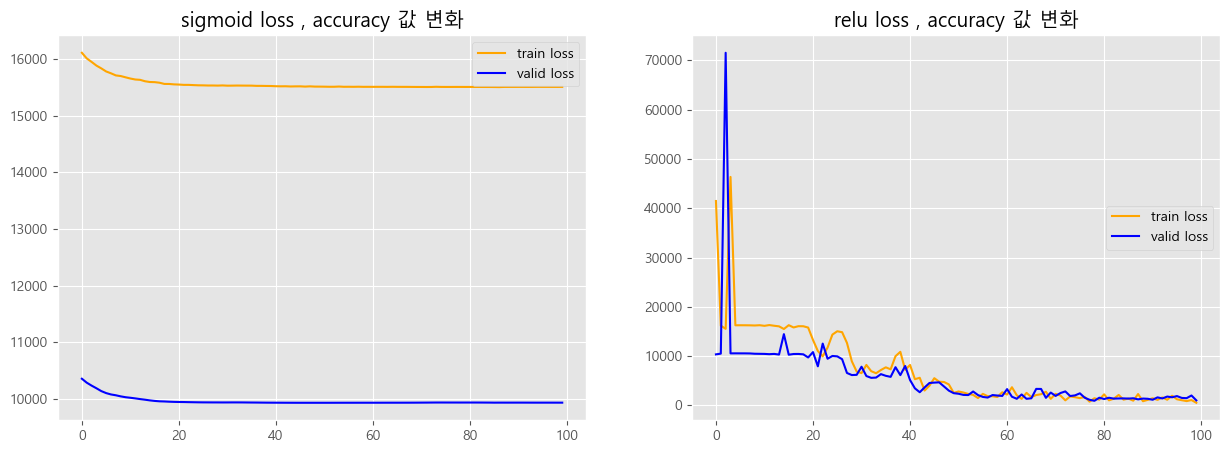

In [38]:
fig,ax = plt.subplots(ncols = 2, figsize = (15,5))

ax[0].plot(normal_history.history['loss'], label = 'train loss', c = 'orange')
ax[0].plot(normal_history.history['val_loss'], label = 'valid loss', c = 'blue')

ax[0].legend()
ax[0].set_title('sigmoid loss , accuracy 값 변화')

ax[1].plot(relu_history.history['loss'], label = 'train loss', c = 'orange')
ax[1].plot(relu_history.history['val_loss'], label = 'valid loss', c = 'blue')
ax[1].legend(loc = 'center right')
ax[1].set_title('relu loss , accuracy 값 변화')

# 2. 배치 정규화 추가

Text(0.5, 1.0, '시그모이드 함수와 시그모이드 도함수 그래프')

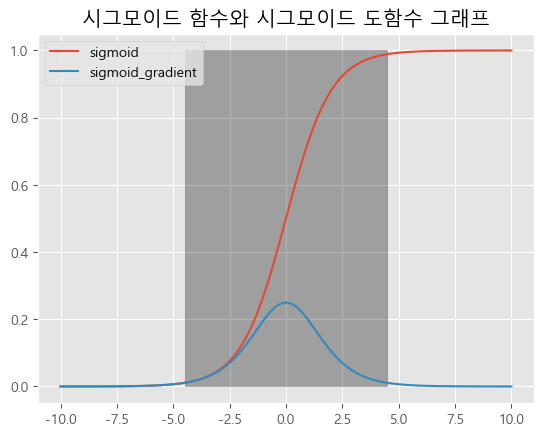

In [39]:
x = np.linspace(-10,10,100)

plt.plot(x,sigmoid(x), label = 'sigmoid')
plt.plot(x,sigmoid_gradient(x), label = 'sigmoid_gradient')

plt.fill_between([-4.5,4.5],[1,1], alpha = 0.3, color ='black')

plt.legend()
plt.title('시그모이드 함수와 시그모이드 도함수 그래프')

* 각 local gradient 의 입력값이 약 -4.5 ~ 4.5 이상이게 되면 해당 local gradient 의 미분 값이 0이 되어 gradient vanishing 문제가 발생하게 된다.
* 이를 방지하기 위해 local gradient 의 입력 값을 배치 정규화를 통해 스케일링 해준다.

In [40]:
def create_batch_model(layers,fx):

    inputs = tf.keras.Input(X.shape[1:])

    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dense(128, activation = fx,
                                kernel_initializer = RandomNormal(mean = 0, stddev = 1))(x) # 초기 딥러닝 모델은 평균이 0이고 표준편차가 1인 곳에서 가중치를 랜덤하게 뽑음

    for layer in range(layers):
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(128, activation = fx)(x) 

    x = tf.keras.layers.BatchNormalization()(x)
    output = tf.keras.layers.Dense(units = 1)(x)

    model = tf.keras.Model(inputs,output)
    
    return model

In [41]:
params = {'layers':30,
            'fx':'sigmoid'}
    
normal_model = create_model(**params) # 배치 정규화가 없는 sigmoid 모델
batch_model = create_batch_model(**params) # 배치 정규화가 있는 sigmoid 모델 

normal_model.compile(**optimizers)
batch_model.compile(**optimizers)

normal_history = normal_model.fit(x_train,y_train,
            epochs = 100,
            validation_data = (x_valid,y_valid),
            verbose = 0)
    

batch_history = batch_model.fit(x_train,y_train,
            epochs = 100,
            validation_data = (x_valid,y_valid),
            verbose = 0)


Text(0.5, 1.0, '배치 정규화 전과 정규화 후의 loss 값 변화 차이')

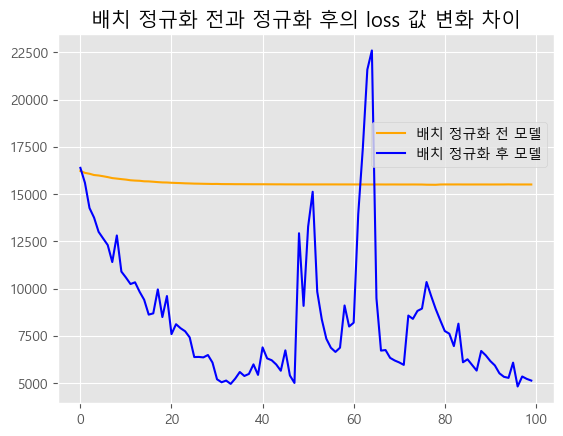

In [42]:
plt.plot(normal_history.history['loss'], c = 'orange',
                                        label = '배치 정규화 전 모델')

plt.plot(batch_history.history['loss'], c = 'blue',
                                        label = '배치 정규화 후 모델')

plt.legend(loc = 'center right',
            bbox_to_anchor = (1,0.7))
plt.title('배치 정규화 전과 정규화 후의 loss 값 변화 차이')